In [1]:
import pandas as pd

# Load the Parquet file
df = pd.read_csv('gkne-dk5s.csv')

# Show basic info
print(df.shape)
print(df.columns)
print(df.head())


(10000000, 19)
Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'imp_surcharge', 'extra', 'rate_code'],
      dtype='object')
  vendor_id          pickup_datetime         dropoff_datetime  \
0       VTS  2014-07-22T23:35:00.000  2014-07-22T23:36:00.000   
1       CMT  2014-08-07T22:31:24.000  2014-08-07T22:35:03.000   
2       VTS  2014-08-12T22:47:00.000  2014-08-12T22:53:00.000   
3       CMT  2014-07-05T02:09:22.000  2014-07-05T02:16:43.000   
4       CMT  2014-09-19T23:18:02.000  2014-09-19T23:32:59.000   

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           0.71        -74.002725        40.728677   
1                2           0.90        -74.004349        40.723741   
2  

In [2]:
# remove null values at lat and lon
df = df.dropna(subset=['dropoff_longitude', 'dropoff_latitude', 'pickup_latitude', 'pickup_longitude'])

In [3]:
import osmnx as ox

# Download the road network for New York City
G = ox.graph_from_place('New York City, New York, USA', network_type='drive')
G_proj = ox.project_graph(G, to_latlong=True)

In [4]:
list(G_proj.edges(data=True))[0:5]

[(39076461,
  274283981,
  {'osmid': 25161349,
   'highway': 'motorway',
   'lanes': '2',
   'maxspeed': '50 mph',
   'name': 'Cross Island Parkway',
   'oneway': True,
   'ref': 'CI',
   'reversed': False,
   'length': 819.5016661477803,
   'geometry': <LINESTRING (-73.795 40.786, -73.795 40.786, -73.794 40.786, -73.794 40.786,...>}),
 (39076461,
  42854803,
  {'osmid': 25161578,
   'highway': 'motorway_link',
   'oneway': True,
   'reversed': False,
   'length': 268.1440952459794,
   'geometry': <LINESTRING (-73.795 40.786, -73.793 40.787, -73.793 40.787, -73.793 40.787,...>}),
 (274283981,
  3789687872,
  {'osmid': [39084897, 40944009, 40944010],
   'highway': 'motorway',
   'lanes': '3',
   'maxspeed': '50 mph',
   'name': 'Cross Island Parkway',
   'oneway': True,
   'ref': 'CI',
   'reversed': False,
   'length': 636.5460273480962,
   'geometry': <LINESTRING (-73.786 40.789, -73.786 40.789, -73.786 40.789, -73.786 40.789,...>,
   'bridge': 'yes'}),
 (42854803,
  42847609,
  {'osm

We have unclassified, residential, tertiary, secondary, primary, trunk, motorway, secondary_link,primary_link, trunk_link, motorway_link for ['highway']

In [5]:
#set a fixed speed limit for all edges based on the road type
dict_speed = {
    'motorway': 70,
    'trunk': 60,
    'primary': 50,
    'secondary': 40,
    'tertiary': 30,
    'residential': 20,
    'unclassified': 15,
    'secondary_link': 30,
    'primary_link': 40,
    'trunk_link': 50,
    'motorway_link': 60,
}

In [6]:
#get an estimated travel time for each edge at G_proj
for u, v, data in G_proj.edges(data=True):
    road_type = data.get('highway', 'residential')  # default to residential if not specified
    # in case it's a list, get the first type
    if isinstance(road_type, list):
        road_type = road_type[0]
    speed_limit = dict_speed.get(road_type, 20)  # default speed limit if road type not found
    data['speed_limit'] = speed_limit
    data['travel_time'] = data['length'] / (speed_limit * 1000 / 3600)  # convert speed to m/s and calculate time in seconds, add 5 seconds for stop time for each edge transition

In [7]:
# add edge weights based on travel time
print(G_proj[42445001][42444991][0])

{'osmid': [1025734022, 1025734023], 'highway': 'primary', 'lanes': '4', 'name': '9th Avenue', 'oneway': True, 'reversed': False, 'length': 87.41343891131758, 'geometry': <LINESTRING (-73.993 40.758, -73.993 40.758, -73.993 40.757, -73.994 40.757,...>, 'speed_limit': 50, 'travel_time': 6.293767601614866}


### Using travel_time (estimated) does give a 1% improvement at the end for xgboost

In [8]:
def recover_route(graph, pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    orig_node = ox.distance.nearest_nodes(graph, pickup_lon, pickup_lat)
    dest_node = ox.distance.nearest_nodes(graph, dropoff_lon, dropoff_lat)

    #print(f"Pickup Node: {orig_node}, Dropoff Node: {dest_node}")
    #print(f"Pickup Coordinates: ({pickup_lat}, {pickup_lon}), Dropoff Coordinates: ({dropoff_lat}, {dropoff_lon})")
    # Compute the shortest path by length (distance)
    # route = ox.shortest_path(graph, orig_node, dest_node, weight='length')
    # Compute the shortest path by travel time
    route = ox.shortest_path(graph, orig_node, dest_node, weight='travel_time')
    return route

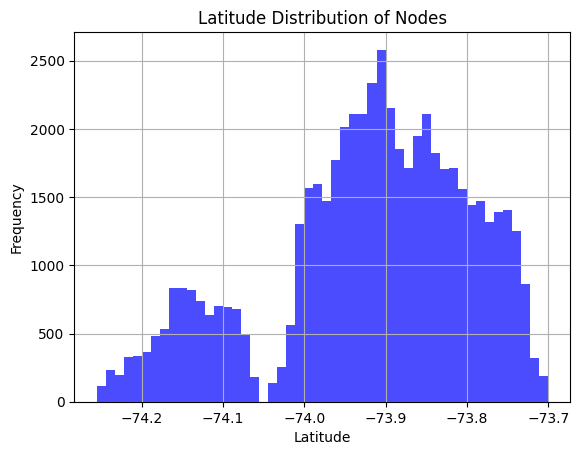

In [9]:
# sanity check for projection
#plot a histogram for lat distribution of nodes
import matplotlib.pyplot as plt
def plot_lat_distribution(graph):
    latitudes = [data['x'] for _, data in graph.nodes(data=True)]
    plt.hist(latitudes, bins=50, color='blue', alpha=0.7)
    plt.title('Latitude Distribution of Nodes')
    plt.xlabel('Latitude')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the latitude distribution of nodes
plot_lat_distribution(G_proj)

In [10]:
recover_route(G_proj, df['pickup_latitude'].iloc[0], df['pickup_longitude'].iloc[0],
              df['dropoff_latitude'].iloc[0], df['dropoff_longitude'].iloc[0])

[4321748237,
 5854302557,
 42430187,
 42430205,
 42430217,
 42430231,
 42430233,
 42430235,
 42430237,
 42421889,
 42430241,
 42430247,
 42430249,
 42429374]

In [11]:
#scale down the data to 25000 rows
df_small = df.sample(n=25000, random_state=42)

In [12]:
pickup_lat = df_small['pickup_latitude']
pickup_lon = df_small['pickup_longitude']
dropoff_lat = df_small['dropoff_latitude']
dropoff_lon = df_small['dropoff_longitude']
df_small['route'] = recover_route(G_proj, pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)

#~70 seconds for 10,000 routes

In [13]:
import pickle
# Save the route to a pickle file
with open('routed_df_25000_shortest.pkl', 'wb') as f:
    pickle.dump(df_small, f)

In [14]:
# save g_proj to a pickle file
with open('g_proj.pkl', 'wb') as f:
    pickle.dump(G_proj, f)

# RESTART FROM HERE

In [15]:
#load the routed dataframe
import pickle
with open('routed_df_25000_shortest.pkl', 'rb') as f:
    df_small = pickle.load(f)

with open('g_proj.pkl', 'rb') as f:
    G_proj = pickle.load(f)

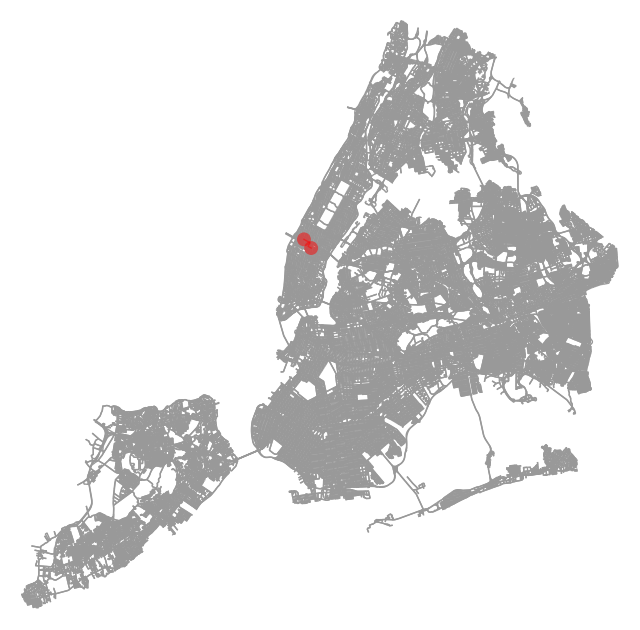

In [16]:
import osmnx as ox
import matplotlib.pyplot as plt

# Example: plot a single route
def plot_route(graph, route):
    fig, ax = ox.plot_graph_route(graph, route, route_linewidth=1, node_size=0, bgcolor='white')
    plt.show()

plot_route(G_proj, df_small['route'].iloc[0])

# Naive modelling

In [17]:
len(G_proj.edges)

139291

In [18]:
len(G_proj.nodes)

55264

In [19]:
df_small['route'].iloc[0]

[np.int64(42437368),
 42435663,
 42437363,
 42439972,
 42439968,
 42439964,
 42433611,
 42428268,
 np.int64(42430317)]

In [20]:
G_proj.edges([42445001])

OutMultiEdgeDataView([(42445001, 42434434), (42445001, 42444991)])

In [21]:
print(G_proj[42445001][42444991][0])  # Length of the edge in meters

{'osmid': [1025734022, 1025734023], 'highway': 'primary', 'lanes': '4', 'name': '9th Avenue', 'oneway': True, 'reversed': False, 'length': 87.41343891131758, 'geometry': <LINESTRING (-73.993 40.758, -73.993 40.758, -73.993 40.757, -73.994 40.757,...>, 'speed_limit': 50, 'travel_time': 6.293767601614866}


In [22]:
#eliminate those with empty routes: disconnected? ~0.4%
df_small = df_small[df_small['route'].apply(lambda x: x is not None and len(x) > 0)]
print(f"Remaining rows after filtering: {df_small.shape[0]}")

Remaining rows after filtering: 24912


In [23]:
def get_edge_length_sum(graph, route):
    edge_length = 0
    if not route:
        print("Warning: The route is empty.")
        return edge_length
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if v not in graph[u]:
            print(f"Warning: Edge {u} to {v} not found in the graph.")
            continue
        length = graph[u][v][0]['length']
        edge_length += length
    return edge_length

In [25]:
import numpy as np

df_small['pickup_datetime'] = pd.to_datetime(df_small['pickup_datetime'])
df_small['dropoff_datetime'] = pd.to_datetime(df_small['dropoff_datetime'])

df_small['duration_seconds'] = (df_small['dropoff_datetime'] - df_small['pickup_datetime']).dt.total_seconds()
#df_small['pickup_hour'] = df_small['pickup_datetime'].dt.hour
# Add sine and cosine transformations for pickup min of the day
df_small['pickup_min_sin'] = np.sin(2 * np.pi * (df_small['pickup_datetime'].dt.hour + df_small['pickup_datetime'].dt.minute/60) / 24)
df_small['pickup_min_cos'] = np.cos(2 * np.pi * (df_small['pickup_datetime'].dt.hour + df_small['pickup_datetime'].dt.minute/60) / 24)

df_small['pickup_weekday'] = df_small['pickup_datetime'].dt.weekday

# Then for each trip get the route length
df_small['route_length'] = df_small['route'].apply(lambda route: get_edge_length_sum(G_proj, route))

In [26]:
df_small.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'imp_surcharge', 'extra', 'rate_code', 'route',
       'duration_seconds', 'pickup_min_sin', 'pickup_min_cos',
       'pickup_weekday', 'route_length'],
      dtype='object')

In [27]:
#print average duration
print(f"Average duration: {df_small['duration_seconds'].mean()} seconds")

Average duration: 785.3892903018625 seconds


In [29]:
from sklearn.model_selection import train_test_split

features = ['route_length','pickup_latitude','pickup_longitude', 'pickup_min_sin', 'pickup_min_cos', 'pickup_weekday', 'passenger_count']
X = df_small[features]
#add lat squared and lon squared
# X['pickup_latitude_squared'] = X['pickup_latitude'] ** 2
# X['pickup_longitude_squared'] = X['pickup_longitude'] ** 2
y = df_small['duration_seconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Baseline MAE: {mae:.2f} seconds")


Baseline MAE: 279.82 seconds


In [31]:
# Install xgboost if not already installed
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))


XGBoost MAE: 229.63841628033114


In [32]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

print("MLP MAE:", mean_absolute_error(y_test, y_pred_mlp))


MLP MAE: 247.24776946024923


### Get features of each type length travelled and number of turns

In [33]:
def get_route_features(graph, route):
    if not route or len(route) < 2:
        print(route)
        return None
    return pd.Series({
        'num_edges': len(route) - 1,
        'motor_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'motorway' or graph[route[i]][route[i + 1]][0].get('highway') == 'motorway_link'),
        'trunk_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'trunk' or graph[route[i]][route[i + 1]][0].get('highway') == 'trunk_link'),
        'primary_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'primary'or graph[route[i]][route[i + 1]][0].get('highway') == 'primary_link'),
        'secondary_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'secondary' or graph[route[i]][route[i + 1]][0].get('highway') == 'secondary_link'),
        'tertiary_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'tertiary'),
        'residential_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'residential'),
        'unclassified_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'unclassified'),
        'motor_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'motorway' or graph[route[i]][route[i + 1]][0].get('highway') == 'motorway_link'),
        'trunk_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'trunk' or graph[route[i]][route[i + 1]][0].get('highway') == 'trunk_link'),
        'primary_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'primary' or graph[route[i]][route[i + 1]][0].get('highway') == 'primary_link'),
        'secondary_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'secondary' or graph[route[i]][route[i + 1]][0].get('highway') == 'secondary_link'),
        'tertiary_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'tertiary'),
        'residential_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'residential'),
        'unclassified_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'unclassified')
    })
    return features

In [34]:
get_route_features(G_proj, df_small['route'].iloc[0])

num_edges                  8.000000
motor_len                  0.000000
trunk_len                  0.000000
primary_len              548.881130
secondary_len            321.842014
tertiary_len               0.000000
residential_len          274.020227
unclassified_len           0.000000
motor_segments             0.000000
trunk_segments             0.000000
primary_segments           2.000000
secondary_segments         4.000000
tertiary_segments          0.000000
residential_segments       2.000000
unclassified_segments      0.000000
dtype: float64

In [36]:
# try XGboost again combining time and route features
#make sure all ['route'] are not None
df_small = df_small[df_small['route'].apply(lambda x: x is not None and len(x) >= 2)]
route_features = df_small['route'].apply(lambda route: get_route_features(G_proj, route))
# Combine route features with the main DataFrame
df_combined = pd.concat([df_small.reset_index(drop=True), route_features.reset_index(drop=True)], axis=1)
# Define features including route features
features_with_route = ['route_length', 'num_edges', 'motor_len', 'trunk_len', 'primary_len', 'secondary_len', 'tertiary_len', 'residential_len', 'unclassified_len',
                       'motor_segments', 'trunk_segments', 'primary_segments', 'secondary_segments', 'tertiary_segments', 'residential_segments','unclassified_segments',
                       'pickup_latitude', 'pickup_longitude', 'pickup_min_sin', 'pickup_min_cos', 'pickup_weekday', 'passenger_count']
X_combined = df_combined[features_with_route]
y_combined = df_combined['duration_seconds']
print(X_combined.shape, y_combined.shape)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

(24223, 22) (24223,)


In [37]:
# get the baseline mae again
model_combined = LinearRegression()
model_combined.fit(X_train_combined, y_train_combined)
y_pred_combined = model_combined.predict(X_test_combined)
mae_combined = mean_absolute_error(y_test_combined, y_pred_combined)
print(f"Baseline MAE with route features: {mae_combined:.2f} seconds")

Baseline MAE with route features: 235.23 seconds


In [38]:
# Train XGBoost model with route features
xgb_model_combined = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model_combined.fit(X_train_combined, y_train_combined)
y_pred_combined = xgb_model_combined.predict(X_test_combined)
print("XGBoost with Route Features MAE:", mean_absolute_error(y_test_combined, y_pred_combined))

XGBoost with Route Features MAE: 210.84375604227478


# W2

In [39]:
# hash uv to get unique edge IDs
import hashlib
def hash_edge(u, v):
    edge_str = f"{u}-{v}"
    return hashlib.md5(edge_str.encode()).hexdigest()
def get_edge_ids(route, G):
    edge_ids = []
    for u, v in zip(route[:-1], route[1:]):
        if G.has_edge(u, v):
            edge_data = G.get_edge_data(u, v)
            # Get unique edge ID or use (u, v)
            edge_ids.append(hash_edge(u,v))
    return edge_ids

In [40]:
from sklearn.preprocessing import LabelEncoder

all_routes = df_small['route'].dropna().tolist()

edge_encoder = LabelEncoder()
# Flatten the list of edge IDs to ensure it's a 1D array
all_edge_ids = [edge for route in all_routes for edge in get_edge_ids(route, G)]
edge_encoder.fit(all_edge_ids)

# Encode per route:
# encoded_routes = [edge_encoder.transform(get_edge_ids(route, G)) for route in all_routes]


LabelEncoder()

In [41]:
#normalize lat and lon
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the scaler on the pickup and dropoff coordinates
scaler.fit(df_small[['pickup_latitude', 'pickup_longitude']])

StandardScaler()

In [42]:
# encode the routes with the lat and lon of each node it went thru 
def encode_routes_with_lat_lon(routes, G):
    encoded_routes = []
    for route in routes:
        if not route or len(route) < 2:
            encoded_routes.append(None)
            continue
        edge_ids = get_edge_ids(route, G)
        if not edge_ids:
            encoded_routes.append(None)
            continue
        # Get the lat/lon for each node in the route
        lat_lon_pairs = [[G.nodes[node]['y'], G.nodes[node]['x']] for node in route]

        #Add some noise to the lat/lon pairs ~11 meters for lat and lon (converted with NYC at ~40.7 degrees latitude)
        lat_lon_pairs = [[lat + np.random.uniform(-0.0001, 0.0001), lon + np.random.uniform(-0.00013, 0.00013)] for lat, lon in lat_lon_pairs]
        # Scale the lat/lon pairs

        # Combine edge IDs with lat/lon pairs
        # encoded_route = [(edge_id, lat, lon) for edge_id, (lat, lon) in zip(edge_ids, lat_lon_pairs)]
        encoded_routes.append(scaler.transform(lat_lon_pairs))
    return encoded_routes

In [43]:
encoded_routes = encode_routes_with_lat_lon(df_small['route'].dropna().tolist(), G_proj)

c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: U

In [44]:
encoded_routes[0:2]

[array([[ 0.04506215, -0.04583602],
        [ 0.04442802, -0.04490189],
        [ 0.0436983 , -0.04394106],
        [ 0.04328544, -0.04407588],
        [ 0.04291676, -0.04428513],
        [ 0.04247941, -0.04441976],
        [ 0.04214458, -0.04456951],
        [ 0.04173389, -0.04408229],
        [ 0.04140914, -0.04358821]]),
 array([[ 0.03399664, -0.05034315],
        [ 0.0344098 , -0.05018677],
        [ 0.03483637, -0.0506963 ],
        [ 0.0351177 , -0.05113451],
        [ 0.0354518 , -0.05095833],
        [ 0.03555043, -0.05092748],
        [ 0.035911  , -0.05075538],
        [ 0.03633423, -0.05063975],
        [ 0.03665741, -0.0505083 ],
        [ 0.03708715, -0.05031218],
        [ 0.03736184, -0.0501944 ],
        [ 0.03780397, -0.05007647],
        [ 0.03808765, -0.04990545],
        [ 0.03853138, -0.04970445],
        [ 0.0389993 , -0.04962389],
        [ 0.03933289, -0.04940385],
        [ 0.0396801 , -0.04930304],
        [ 0.04003945, -0.04907971],
        [ 0.04043819, -0.0

In [45]:
# padding the encoded routes to have the same length
import numpy as np
def pad_encoded_routes(encoded_routes, max_length):
    padded_routes = []
    for route in encoded_routes:
        if route is None:
            padded_routes.append(np.full((max_length, 2), 0))  # Fill with 0 if route is None
        else:
            padded_route = np.array(route)
            if len(padded_route) < max_length:
                # Pad with NaN if the route is shorter than max_length
                padding = np.full((max_length - len(padded_route), 2), 0)
                padded_route = np.vstack((padded_route, padding))
            elif len(padded_route) > max_length:
                # Truncate if the route is longer than max_length
                padded_route = padded_route[:max_length]
            padded_routes.append(padded_route)
    return np.array(padded_routes)
max_route_length = max(len(route) for route in df_small['route'].dropna().tolist())
padded_routes = pad_encoded_routes(encoded_routes, max_route_length)



In [46]:
padded_routes.shape

(24223, 256, 2)

In [ ]:
import torch

# Sequence input: (B, N, 2) where B=batch, N=#points, 2=(lat, lon)
seq_input = torch.tensor(padded_routes, dtype=torch.float32)  # shape: (B, N, 2)

features = ['route_length', 'pickup_min_sin', 'pickup_min_cos', 'pickup_weekday', 'pickup_weekday', 'passenger_count', 'trip_distance']
# Scalar input: (B, F)
scalar_input = torch.tensor(np.array(df_small[features]), dtype=torch.float32)  # shape: (B, F)

# Output: ETA in seconds
eta_target = torch.tensor(np.array(df_small['duration_seconds']), dtype=torch.float32)  # shape: (B,)


In [66]:
seq_input.shape, scalar_input.shape, eta_target.shape

(torch.Size([24223, 256, 2]), torch.Size([24223, 7]), torch.Size([24223]))

In [67]:
#take 20% of seq,scalar, and eta for testing
seq_test, seq_input, scalar_test, scalar_input, eta_test, eta_target, attention_mask_test, attention_mask = train_test_split(
    seq_input, scalar_input, eta_target, attention_mask, test_size=0.2, random_state=42)

In [68]:
import torch
import torch.nn as nn

class ETA_Transformer(nn.Module):
    def __init__(self, seq_dim=2, scalar_dim=7, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(seq_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(500, d_model))  # max 500 points
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.scalar_proj = nn.Linear(scalar_dim, d_model)
        self.output_head = nn.Sequential(
            nn.Linear(d_model * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))


    def forward(self, route_seq, scalar_feats, attention_mask):
        """
        route_seq: (B, N, 2)
        scalar_feats: (B, F)
        """
        B, N, _ = route_seq.size()
        x = self.input_proj(route_seq)  # (B, N, d_model)

        
        cls_tokens = self.cls_token.expand(B, 1, -1)  # (B, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, d_model)

        x = x + self.pos_encoding[:N+1]  # add positional encoding, N+1 because of [CLS] token

        x = self.transformer(x, src_key_padding_mask=(attention_mask == 0))  # (B, N, d_model)
        route_embedding = x[:, 0, :]  # [CLS] token output
        
        mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
        masked_x = x * mask  # zero out padding
        route_embedding = masked_x.sum(1) / mask.sum(1)  # (B, d_model)
        #route_embedding = x.mean(dim=1)  # (B, d_model)

        scalar_embedding = self.scalar_proj(scalar_feats)  # (B, d_model)
        combined = torch.cat([route_embedding, scalar_embedding], dim=1)  # (B, 2*d_model)

        eta_pred = self.output_head(combined).squeeze(-1)  # (B,)
        return eta_pred


In [ ]:
model = ETA_Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()
epochs = 13

In [70]:
for epoch in range(epochs):
    model.train()
    #sample a 10% batch
    batch_size = int(0.10 * seq_input.shape[0])
    indices = torch.randperm(seq_input.shape[0])[:batch_size]
    seq_input_batch = seq_input[indices]
    scalar_input_batch = scalar_input[indices]
    eta_target_batch = eta_target[indices]
    attention_mask_batch = attention_mask[indices]

    pred = model(seq_input_batch, scalar_input_batch,attention_mask_batch)
    loss = loss_fn(pred, eta_target_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    print(f"Epoch {epoch+1}, Loss: {loss.item():.2f}")
    # print validation loss
    with torch.no_grad():
        model.eval()
        pred_test = model(seq_test, scalar_test, attention_mask_test)
        test_loss = loss_fn(pred_test, eta_test)
        print(f"Validation Loss: {test_loss.item():.2f}")


Epoch 1, Loss: 1258772.25


c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Validation Loss: 1022942.94
Epoch 2, Loss: 1030975.62
Validation Loss: 833716.19
Epoch 3, Loss: 772964.62
Validation Loss: 676208.31
Epoch 4, Loss: 622735.75
Validation Loss: 549892.25
Epoch 5, Loss: 656633.19
Validation Loss: 454166.03
Epoch 6, Loss: 374191.25
Validation Loss: 385747.06
Epoch 7, Loss: 333917.84
Validation Loss: 339304.84
Epoch 8, Loss: 347874.50
Validation Loss: 309748.81
Epoch 9, Loss: 385431.62
Validation Loss: 294390.03
Epoch 10, Loss: 234034.39
Validation Loss: 291104.09


In [71]:
# Save the model
torch.save(model.state_dict(), 'eta_transformer_model.pth')

In [72]:
#evaluate the model
model.eval()
with torch.no_grad():
    #use the test set
    pred_test = model(seq_test, scalar_test, attention_mask_test)
    test_loss = loss_fn(pred_test, eta_test)
    print(f"Test Loss: {test_loss.item():.2f}")
    

Test Loss: 291104.09
